In [15]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#set directories
workDir = "/Users/czkaiweb/Research/DisappTrksML/VAE/"
saveDir = workDir
dataDir = "/Users/czkaiweb/Research/DisappTrkMLData/converted/"

#load data
data_e = np.load(dataDir+'e_DYJets50V3_norm_40x40_nonscaled.npy')
data_bkg = np.load(dataDir+'bkg_DYJets50V3_norm_40x40_nonscaled.npy')


#save 20% of data for testing
test_index_e = int(len(data_e)/5)
test_index_bkg = int(len(data_bkg)/5)

#shuffle e and bkg data
indicies = np.arange(len(data_e))
np.random.shuffle(indicies)
data_e = data_e[indicies]
indicies = np.arange(len(data_bkg))
np.random.shuffle(indicies)
data_bkg = data_bkg[indicies]

#test data
test_e = data_e[:test_index_e]
test_bkg = data_bkg[:test_index_bkg]

data = np.concatenate([data_e[test_index_e:], data_bkg[test_index_bkg:]])
classes = np.concatenate([np.ones(len(data_e[test_index_e:])), np.zeros(len(data_bkg[test_index_bkg:]))])
print(len(data_e), len(data_bkg))


input_train, input_test, target_train,target_test = train_test_split(data, classes, test_size=0.15, random_state=0)
#################################################

# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 5
num_channels = input_train.shape[3]

# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)

input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')


5528 22682


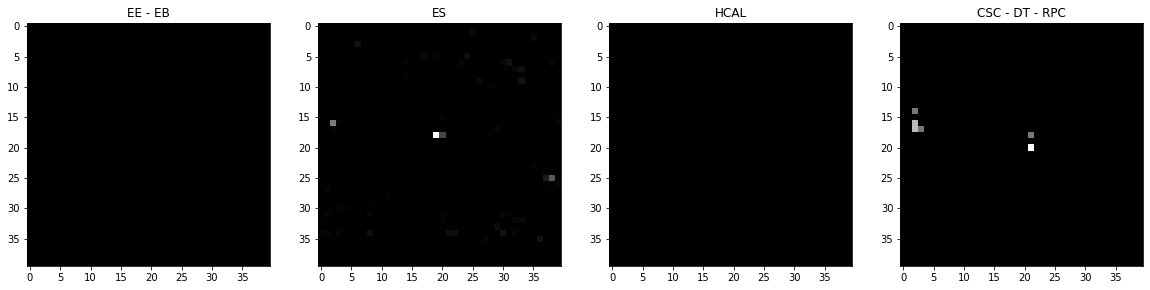

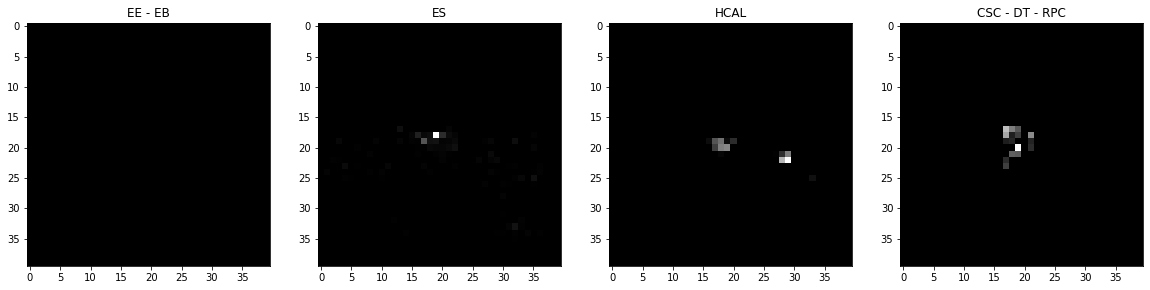

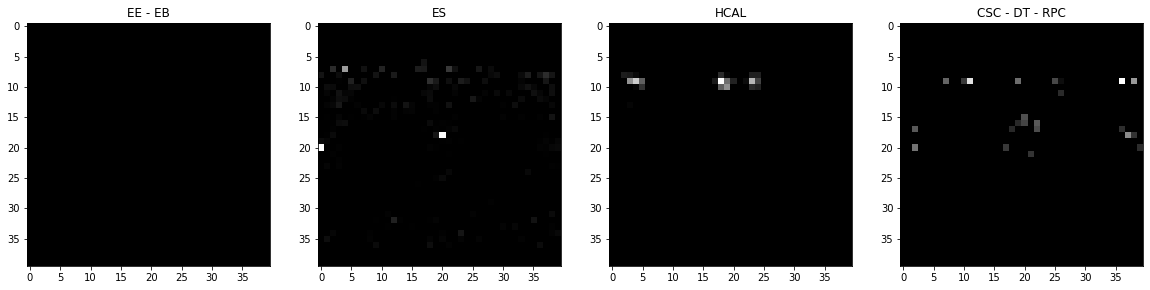

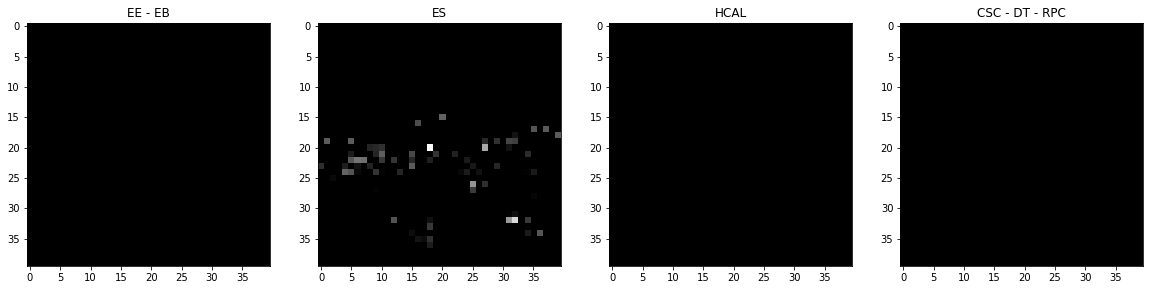

In [20]:
def plot_event(x):
    
    fig, axs = plt.subplots(1,4,figsize=(20,20))
    
    for i in range(4):
        axs[i].imshow(x[:,:,i],cmap='gray')
    
    axs[0].set_title("EE - EB")
    axs[1].set_title("ES")
    axs[2].set_title("HCAL")
    axs[3].set_title("CSC - DT - RPC")
    
    plt.show()



plot_event(data_e[4576])
plot_event(data_e[123])
plot_event(data_e[3453])

plot_event(data_bkg[0])


In [4]:
# Normalize data
#input_train = input_train / 255
#input_test = input_test / 255

# # =================
# # Encoder
# # =================

# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

# Use reparameterization trick to ....??
z  = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

# =================
# Decoder
# =================

# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()


# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

# Compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

# Train autoencoder
history = vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 40, 40, 5)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 8)    368         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 20, 20, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 10, 10, 16)   1168        batch_normalization_1[0][0]      
____________________________________________________________________________________________

Epoch 29/100
15346/15346 [==============================] - 16s 1ms/step - loss: -117.9494 - val_loss: -105.1120
Epoch 30/100
15346/15346 [==============================] - 17s 1ms/step - loss: -120.0097 - val_loss: -106.0187
Epoch 31/100
15346/15346 [==============================] - 17s 1ms/step - loss: -120.9182 - val_loss: -106.6625
Epoch 32/100
15346/15346 [==============================] - 16s 1ms/step - loss: -122.7088 - val_loss: -109.8334
Epoch 33/100
15346/15346 [==============================] - 17s 1ms/step - loss: -124.0667 - val_loss: -109.9072
Epoch 34/100
15346/15346 [==============================] - 17s 1ms/step - loss: -124.6539 - val_loss: -111.0154
Epoch 35/100
15346/15346 [==============================] - 17s 1ms/step - loss: -127.1635 - val_loss: -112.6967
Epoch 36/100
15346/15346 [==============================] - 17s 1ms/step - loss: -127.2979 - val_loss: -113.5718
Epoch 37/100
15346/15346 [==============================] - 18s 1ms/step - loss: -128.8391 - val

In [1]:
# =================
# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/
# (François Chollet).
# Adapted to accomodate this VAE.
# =================

def viz_latent_space(encoder, data, proj_list):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(8, 6))
    plt.scatter(mu[:, proj_list[0]], mu[:, proj_list[1]], c=target_data, s=1)
    plt.xlabel('z - dim '+ str(proj_list[0]))
    plt.ylabel('z - dim '+ str(proj_list[1]))
    plt.colorbar()
    plt.show()


# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data,[0,1])
viz_latent_space(encoder, data,[0,2])
viz_latent_space(encoder, data,[0,3])
viz_latent_space(encoder, data,[0,4])
viz_latent_space(encoder, data,[1,2])
viz_latent_space(encoder, data,[1,3])
viz_latent_space(encoder, data,[1,4])
viz_latent_space(encoder, data,[2,3])
viz_latent_space(encoder, data,[2,4])
viz_latent_space(encoder, data,[3,4])

NameError: name 'input_test' is not defined

In [11]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


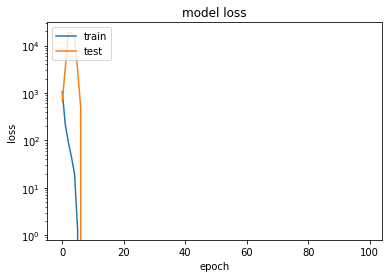

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.show()